# Задание 5.2 - Word2Vec with Negative Sampling

В этом задании мы натренируем свои версию word vectors с negative sampling на том же небольшом датасете.


Несмотря на то, что основная причина использования Negative Sampling - улучшение скорости тренировки word2vec, в нашем игрушечном примере мы **не требуем** улучшения производительности. Мы используем negative sampling просто как дополнительное упражнение для знакомства с PyTorch.

Перед запуском нужно запустить скрипт `download_data.sh`, чтобы скачать данные.

Датасет и модель очень небольшие, поэтому это задание можно выполнить и без GPU.



In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset

from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt

# We'll use Principal Component Analysis (PCA) to visualize word vectors,
# so make sure you install dependencies from requirements.txt!
from sklearn.decomposition import PCA 

%matplotlib inline

In [5]:
device = torch.device("cuda:0")

In [6]:
class StanfordTreeBank:
    '''
    Wrapper for accessing Stanford Tree Bank Dataset
    https://nlp.stanford.edu/sentiment/treebank.html
    
    Parses dataset, gives each token and index and provides lookups
    from string token to index and back
    
    Allows to generate random context with sampling strategy described in
    word2vec paper:
    https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf
    '''
    def __init__(self):
        self.index_by_token = {} # map of string -> token index
        self.token_by_index = []

        self.sentences = []

        self.token_freq = {}
        
        self.token_reject_by_index = None

    def load_dataset(self, folder):
        filename = os.path.join(folder, "datasetSentences.txt")

        with open(filename, "r", encoding="latin1") as f:
            l = f.readline() # skip the first line
            
            for l in f:
                splitted_line = l.strip().split()
                words = [w.lower() for w in splitted_line[1:]] # First one is a number
                    
                self.sentences.append(words)
                for word in words:
                    if word in self.token_freq:
                        self.token_freq[word] +=1 
                    else:
                        index = len(self.token_by_index)
                        self.token_freq[word] = 1
                        self.index_by_token[word] = index
                        self.token_by_index.append(word)
        self.compute_token_prob()
                        
    def compute_token_prob(self):
        words_count = np.array([self.token_freq[token] for token in self.token_by_index])
        words_freq = words_count / np.sum(words_count)
        
        # Following sampling strategy from word2vec paper
        self.token_reject_by_index = 1- np.sqrt(1e-5/words_freq)
    
    def check_reject(self, word):
        return np.random.rand() > self.token_reject_by_index[self.index_by_token[word]]
        
    def get_random_context(self, context_length=5):
        """
        Returns tuple of center word and list of context words
        """
        sentence_sampled = []
        while len(sentence_sampled) <= 2:
            sentence_index = np.random.randint(len(self.sentences)) 
            sentence = self.sentences[sentence_index]
            sentence_sampled = [word for word in sentence if self.check_reject(word)]
    
        center_word_index = np.random.randint(len(sentence_sampled))
        
        words_before = sentence_sampled[max(center_word_index - context_length//2,0):center_word_index]
        words_after = sentence_sampled[center_word_index+1: center_word_index+1+context_length//2]
        
        return sentence_sampled[center_word_index], words_before+words_after
    
    def num_tokens(self):
        return len(self.token_by_index)
        
data = StanfordTreeBank()
data.load_dataset("./stanfordSentimentTreebank/")

print("Num tokens:", data.num_tokens())
for i in range(5):
    center_word, other_words = data.get_random_context(5)
    print(center_word, other_words)

Num tokens: 19538
written ['hawn', 'bluntly', 'trace', 'blisteringly']
tight ['role', 'giving', 'focused', 'illuminated']
daughter ['danang', 'that']
pta ['primavera', 'proud', 'muccino']
task ['johnson', 'nearly']


# Dataset для Negative Sampling должен быть немного другим

Как и прежде, Dataset должен сгенерировать много случайных контекстов и превратить их в сэмплы для тренировки.

Здесь мы реализуем прямой проход модели сами, поэтому выдавать данные можно в удобном нам виде.
Напоминаем, что в случае negative sampling каждым сэмплом является:
- вход: слово в one-hot представлении
- выход: набор из одного целевого слова и K других случайных слов из словаря.
Вместо softmax + cross-entropy loss, сеть обучается через binary cross-entropy loss - то есть, предсказывает набор бинарных переменных, для каждой из которых функция ошибки считается независимо.

Для целевого слова бинарное предсказание должно быть позитивным, а для K случайных слов - негативным.

Из набора слово-контекст создается N сэмплов (где N - количество слов в контексте), в каждом из них K+1 целевых слов, для только одного из которых предсказание должно быть позитивным.
Например, для K=2:

Слово: `orders` и контекст: `['love', 'nicest', 'to', '50-year']` создадут 4 сэмпла:
- input: `orders`, target: `[love: 1, any: 0, rose: 0]`
- input: `orders`, target: `[nicest: 1, fool: 0, grass: 0]`
- input: `orders`, target: `[to: 1, -: 0, the: 0]`
- input: `orders`, target: `[50-year: 1, ?: 0, door: 0]`

Все слова на входе и на выходе закодированы через one-hot encoding, с размером вектора равным количеству токенов.

In [7]:
num_negative_samples = 10

class Word2VecNegativeSampling(Dataset):
    '''
    PyTorch Dataset for Word2Vec with Negative Sampling.
    Accepts StanfordTreebank as data and is able to generate dataset based on
    a number of random contexts
    '''
    def __init__(self, data, num_negative_samples, num_contexts=30000):
        '''
        Initializes Word2VecNegativeSampling, but doesn't generate the samples yet
        (for that, use generate_dataset)
        Arguments:
        data - StanfordTreebank instace
        num_negative_samples - number of negative samples to generate in addition to a positive one
        num_contexts - number of random contexts to use when generating a dataset
        '''
        self.data = data
        self.num_negative_samples = num_negative_samples
        self.num_contexts = num_contexts
        self.num_tokens = data.num_tokens()
    
    def generate_dataset(self):
        '''
        Generates dataset samples from random contexts
        Note: there will be more samples than contexts because every context
        can generate more than one sample
        '''
        self.samples = []
        for _ in range(self.num_contexts):
            word, context = self.data.get_random_context()
            for target in context:
                word_index = self.data.index_by_token[word]
                target_index = self.data.index_by_token[target]
                
                output_indices = np.random.randint(self.num_tokens, size=self.num_negative_samples+1, dtype=np.int64)
                output_indices = torch.from_numpy(output_indices)
                output_indices[0] = target_index
                
                output_target = torch.zeros(self.num_negative_samples+1, dtype=torch.float32)
                output_target[0] = 1.0
                
                sample = (word_index, output_indices, output_target)
                self.samples.append(sample)
        
    def __len__(self):
        '''
        Returns total number of samples
        '''
        return len(self.samples)

    
    def __getitem__(self, index):
        '''
        Returns i-th sample
        
        Return values:
        input_vector - index of the input word (not torch.Tensor!)
        output_indices - torch.Tensor of indices of the target words. Should be 1+num_negative_samples.
        output_target - torch.Tensor with float targets for the training. Should be the same size as output_indices
                        and have 1 for the context word and 0 everywhere else
        '''
        return self.samples[index]

dataset = Word2VecNegativeSampling(data, num_negative_samples, 10)
dataset.generate_dataset()
input_vector, output_indices, output_target = dataset[0]

print("Sample - input: %s, output indices: %s, output target: %s" % (int(input_vector), output_indices, output_target)) # target should be able to convert to int
assert isinstance(output_indices, torch.Tensor)
assert output_indices.shape[0] == num_negative_samples+1

assert isinstance(output_target, torch.Tensor)
assert output_target.shape[0] == num_negative_samples+1
assert torch.sum(output_target) == 1.0

Sample - input: 1095, output indices: tensor([ 1179,  4549,  7501,  8465, 16355,  9006, 18670, 10880,  6167, 17685,
         8788]), output target: tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


# Создаем модель

Для нашей задачи нам придется реализовать свою собственную PyTorch модель.
Эта модель реализует свой собственный прямой проход (forward pass), который получает на вход индекс входного слова и набор индексов для выходных слов. 

Как всегда, на вход приходит не один сэмпл, а целый batch.  
Напомним, что цели улучшить скорость тренировки у нас нет, достаточно чтобы она сходилась.

In [8]:
# Create the usual PyTorch structures
dataset = Word2VecNegativeSampling(data, num_negative_samples, 30000)
dataset.generate_dataset()

# As before, we'll be training very small word vectors!
wordvec_dim = 10

class Word2VecNegativeSamples(nn.Module):
    def __init__(self, num_tokens):
        super(Word2VecNegativeSamples, self).__init__()
        self.input = nn.Linear(num_tokens, 10, bias=False).to(device)
        self.output = nn.Linear(10, num_tokens, bias=False).to(device)
        
    def forward(self, input_index_batch, output_indices_batch):
        '''
        Implements forward pass with negative sampling
        
        Arguments:
        input_index_batch - Tensor of ints, shape: (batch_size, ), indices of input words in the batch
        output_indices_batch - Tensor if ints, shape: (batch_size, num_negative_samples+1),
                                indices of the target words for every sample
                                
        Returns:
        predictions - Tensor of floats, shape: (batch_size, um_negative_samples+1)
        '''
        predictions = []
        
        for i, input_index in enumerate(input_index_batch):
            output_indices = output_indices_batch[i]
            
            u = self.input.weight[:, input_index]
            v = self.output.weight[output_indices, :]
            
            prediction = torch.mv(v, u)
            predictions.append(prediction)
        
        return torch.stack(predictions)
    
nn_model = Word2VecNegativeSamples(data.num_tokens())
nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

Word2VecNegativeSamples(
  (input): Linear(in_features=19538, out_features=10, bias=False)
  (output): Linear(in_features=10, out_features=19538, bias=False)
)

In [18]:
def extract_word_vectors(nn_model):
    '''
    Extracts word vectors from the model
    
    Returns:
    input_vectors: torch.Tensor with dimensions (num_tokens, num_dimensions)
    output_vectors: torch.Tensor with dimensions (num_tokens, num_dimensions)
    '''
    input_vectors = nn_model.input.weight.data.cpu().T
    output_vectors = nn_model.output.weight.cpu().data
    
    return input_vectors, output_vectors

untrained_input_vectors, untrained_output_vectors = extract_word_vectors(nn_model)
assert untrained_input_vectors.shape == (data.num_tokens(), wordvec_dim)
assert untrained_output_vectors.shape == (data.num_tokens(), wordvec_dim)

In [10]:
def train_neg_sample(model, dataset, train_loader, optimizer, num_epochs, scheduler=None, scheduler_loss=False):    
    '''
    Trains word2vec with negative samples on and regenerating dataset every epoch
    
    Returns:
    loss_history, train_history
    '''
    loss = nn.BCEWithLogitsLoss().type(torch.FloatTensor)
    loss_history = []
    train_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        dataset.generate_dataset()
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        
        for i_step, (x, indicies, y) in enumerate(train_loader):
            x_gpu = x.to(device)
            indicies_gpu = indicies.to(device)
            y_gpu = y.to(device)
            predictions = model(x_gpu, indicies_gpu)
            loss_value = loss(predictions, y_gpu)
        
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            max_preds = torch.argmax(predictions, 1)
            max_y = torch.argmax(y_gpu, 1)
            correct_samples += torch.sum(max_preds == max_y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value
        
        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        
        if scheduler:
            if scheduler_loss:
                scheduler.step(ave_loss)
            else:
                scheduler.step()
            
        print("Epoch %i, Average loss: %f, Train accuracy: %f" % (epoch, ave_loss, train_accuracy))
        
    return loss_history, train_history

# Ну и наконец тренировка!

Добейтесь значения ошибки меньше **0.25**.

In [11]:
import itertools
from collections import namedtuple

In [12]:
def param_search(learning_rates, reg_strengths, factors, patience_list, num_epochs=10):
    run_records = {}
  
    Hyperparams = namedtuple("Hyperparams", ['learning_rates', 'reg_strengths', 'factors', 'patience'])
    RunResult = namedtuple("RunResult", ['model', 'train_history', 'loss_history'])

    param_list = [learning_rates, reg_strengths, factors, patience_list]
    param_combs = list(itertools.product(*param_list))
    indicies = np.random.choice(len(param_combs), size=15, replace=False)
    for idx in indicies:
        lr, reg, factor, patience = param_combs[idx]

        model = Word2VecNegativeSamples(data.num_tokens())
        model.type(torch.cuda.FloatTensor)
        model = model.to(device)

        optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=reg)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=factor, patience=patience)

        print(f'lr: {lr}, reg: {reg}, factor: {factor}, patience: {patience}')
        loss_history, train_history = train_neg_sample(model, dataset, train_loader, optimizer, num_epochs, scheduler, True)

        params = Hyperparams(lr, reg, factor, patience)
        run_results = RunResult(model, train_history, loss_history)
        run_records[params] = run_results

        print('\n\n')

    return run_records

In [14]:
learning_rates = [30, 20, 10]
reg_strengths = [0]
factors = [0.1, 0.3, 0.5, 0.7]
patience_list = [1, 2, 3]

train_loader = torch.utils.data.DataLoader(dataset, batch_size=20)

run_records = param_search(learning_rates, reg_strengths, factors, patience_list)

lr: 20, reg: 0, factor: 0.5, patience: 2
Epoch 0, Average loss: 0.693171, Train accuracy: 0.100085
Epoch 1, Average loss: 0.648856, Train accuracy: 0.147761
Epoch 2, Average loss: 0.433226, Train accuracy: 0.254769
Epoch 3, Average loss: 0.326432, Train accuracy: 0.290643
Epoch 4, Average loss: 0.296007, Train accuracy: 0.303784
Epoch 5, Average loss: 0.285341, Train accuracy: 0.305598
Epoch 6, Average loss: 0.278186, Train accuracy: 0.312720
Epoch 7, Average loss: 0.274752, Train accuracy: 0.313037
Epoch 8, Average loss: 0.271614, Train accuracy: 0.317811
Epoch 9, Average loss: 0.269403, Train accuracy: 0.323585



lr: 30, reg: 0, factor: 0.5, patience: 2
Epoch 0, Average loss: 0.685597, Train accuracy: 0.108607
Epoch 1, Average loss: 0.471517, Train accuracy: 0.220343
Epoch 2, Average loss: 0.330333, Train accuracy: 0.274356
Epoch 3, Average loss: 0.300471, Train accuracy: 0.289687
Epoch 4, Average loss: 0.288597, Train accuracy: 0.297551
Epoch 5, Average loss: 0.282877, Train accura

In [15]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=20)

best_model = Word2VecNegativeSamples(data.num_tokens())
best_model.type(torch.cuda.FloatTensor)
best_model.to(device)

optimizer = optim.SGD(best_model.parameters(), lr=30, weight_decay=0)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=2)
loss_history, train_history = train_neg_sample(best_model, dataset, train_loader, optimizer, 50, scheduler, True)

Epoch 0, Average loss: 0.691142, Train accuracy: 0.103037
Epoch 1, Average loss: 0.514989, Train accuracy: 0.203138
Epoch 2, Average loss: 0.337739, Train accuracy: 0.276586
Epoch 3, Average loss: 0.304681, Train accuracy: 0.287299
Epoch 4, Average loss: 0.289784, Train accuracy: 0.294818
Epoch 5, Average loss: 0.283144, Train accuracy: 0.301111
Epoch 6, Average loss: 0.277026, Train accuracy: 0.313882
Epoch 7, Average loss: 0.273121, Train accuracy: 0.324681
Epoch 8, Average loss: 0.268441, Train accuracy: 0.337409
Epoch 9, Average loss: 0.263742, Train accuracy: 0.353646
Epoch 10, Average loss: 0.258879, Train accuracy: 0.367201
Epoch 11, Average loss: 0.254477, Train accuracy: 0.384514
Epoch 12, Average loss: 0.250156, Train accuracy: 0.401112
Epoch 13, Average loss: 0.244921, Train accuracy: 0.418815
Epoch 14, Average loss: 0.242235, Train accuracy: 0.428544
Epoch 15, Average loss: 0.238963, Train accuracy: 0.442085
Epoch 16, Average loss: 0.236100, Train accuracy: 0.451344
Epoch 1

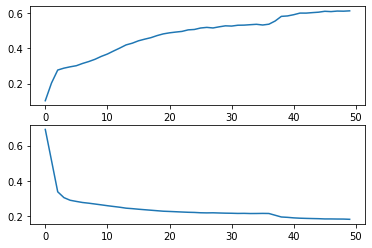

In [16]:
# Visualize training graphs
plt.subplot(211)
plt.plot(train_history)
plt.subplot(212)
plt.plot(loss_history)

# Визуализируем вектора для разного вида слов до и после тренировки

Как и ранее, в случае успешной тренировки вы должны увидеть как вектора слов разных типов (например, знаков препинания, предлогов и остальных)

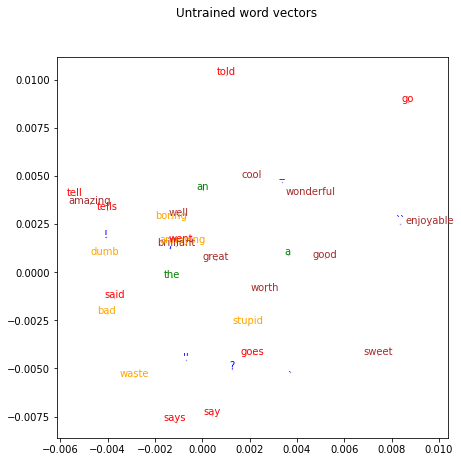

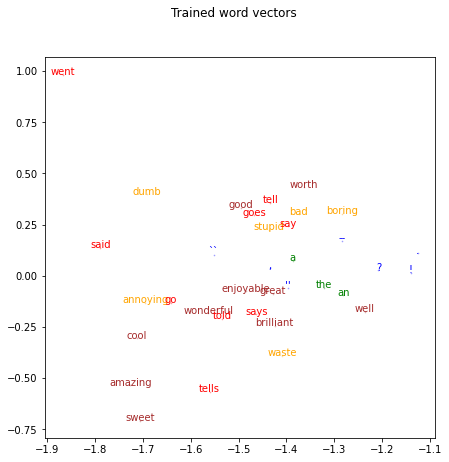

In [19]:
trained_input_vectors, trained_output_vectors = extract_word_vectors(best_model)
assert trained_input_vectors.shape == (data.num_tokens(), wordvec_dim)
assert trained_output_vectors.shape == (data.num_tokens(), wordvec_dim)

def visualize_vectors(input_vectors, output_vectors, title=''):
    full_vectors = torch.cat((input_vectors, output_vectors), 0)
    wordvec_embedding = PCA(n_components=2).fit_transform(full_vectors)

    # Helpful words form CS244D example
    # http://cs224d.stanford.edu/assignment1/index.html
    visualize_words = {'green': ["the", "a", "an"], 
                      'blue': [",", ".", "?", "!", "``", "''", "--"], 
                      'brown': ["good", "great", "cool", "brilliant", "wonderful", 
                              "well", "amazing", "worth", "sweet", "enjoyable"],
                      'orange': ["boring", "bad", "waste", "dumb", "annoying", "stupid"],
                      'red': ['tell', 'told', 'said', 'say', 'says', 'tells', 'goes', 'go', 'went']
                     }

    plt.figure(figsize=(7,7))
    plt.suptitle(title)
    for color, words in visualize_words.items():
        points = np.array([wordvec_embedding[data.index_by_token[w]] for w in words])
        for i, word in enumerate(words):
            plt.text(points[i, 0], points[i, 1], word, color=color,horizontalalignment='center')
        plt.scatter(points[:, 0], points[:, 1], c=color, alpha=0.3, s=0.5)

visualize_vectors(untrained_input_vectors, untrained_output_vectors, "Untrained word vectors")
visualize_vectors(trained_input_vectors, trained_output_vectors, "Trained word vectors")